I was working on a movie recommendation system project. While content-based filtering could recommend similar movies based on genre or tags, and collaborative filtering could learn from user preferences, both approaches had limitations when used alone.
Content-based systems lacked diversity, while collaborative filtering struggled with new users or movies.

My task was to build a hybrid recommendation system that could combine the strengths of both approaches — to provide more accurate and personalized movie recommendations, even in cold-start scenarios.

I followed a structured process:

Data Preparation: Used a movie ratings dataset (like MovieLens), and combined it with metadata such as genres, tags, and movie descriptions.

Content-Based Filtering:

Created TF-IDF vectors from movie genres and tags.

Calculated cosine similarity to find movies similar to a user’s liked movies.

Collaborative Filtering:

Used SVD to learn latent factors for users and items from the rating matrix.

Hybrid Model:

Combined both scores:

For each user, I gave weights to content similarity and predicted ratings from SVD.

This gave a personalized and diverse recommendation list, even for users with very few ratings.

The hybrid recommendation system provided more relevant and personalized movie suggestions by combining both user preferences and movie characteristics.
It overcame common limitations like the cold-start problem by using content features for new users or movies.
Users received a balanced mix of familiar and diverse movie options — improving both user satisfaction and discovery.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2469544 sha256=261346de29ad7ff34981e3bfd928d4e5c8ddac7b44372f5d4976373557ed1f7f
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [3]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [6]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [7]:
df = pd.merge(movies[['movieId', 'title']], ratings, on='movieId', how = 'right')

In [8]:
df_ratings = df.drop(columns = 'timestamp')

In [9]:
df_ratings.shape

(1469763, 4)

In [10]:
df_ratings['movie_release_year'] = df_ratings['title'].str.extract(r'\((\d{4})\)')
df_ratings['movie_name'] = df_ratings['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [11]:
print('total number of customers', df_ratings['userId'].nunique())
print('total number of movies', df_ratings['movieId'].nunique())
print('unique years', df_ratings['movie_release_year'].nunique())

total number of customers 9818
total number of movies 24167
unique years 116


In [12]:
customer_list15 = df.groupby('userId')['rating'].count().sort_values(ascending = False).reset_index().query('rating > 15')['userId'].tolist()

In [13]:
ratings = df_ratings[df_ratings['userId'].isin(customer_list15)]

In [14]:
top_movie_rating_count = ratings.groupby('movie_name')['rating'].count().sort_values(ascending = False).reset_index().head(10)

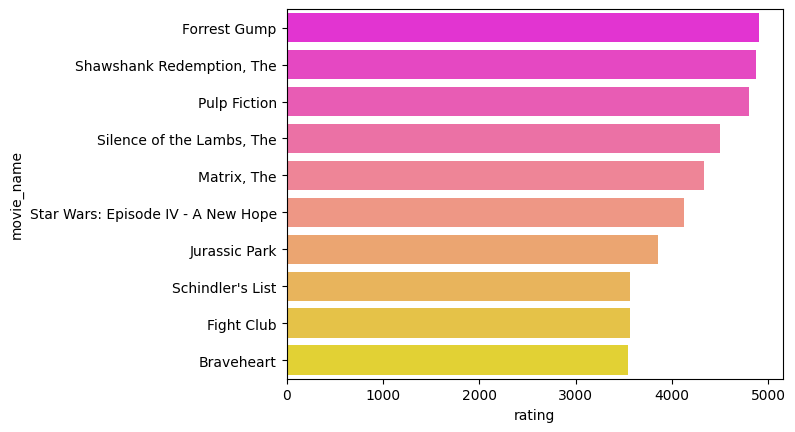

In [15]:
sns.barplot(data = top_movie_rating_count, y = 'movie_name', x = 'rating', palette = 'spring')
plt.show()

In [16]:
top_year_released = ratings.groupby('movie_release_year')['movie_name'].count().sort_values(ascending = False).reset_index().head(10)

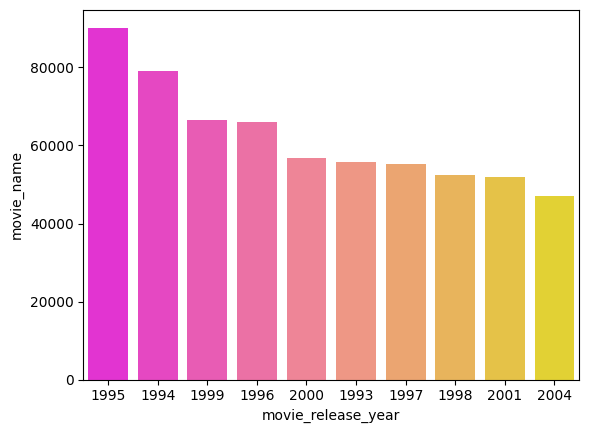

In [17]:
sns.barplot(data = top_year_released, x = 'movie_release_year', y = 'movie_name', palette = 'spring')
plt.show()

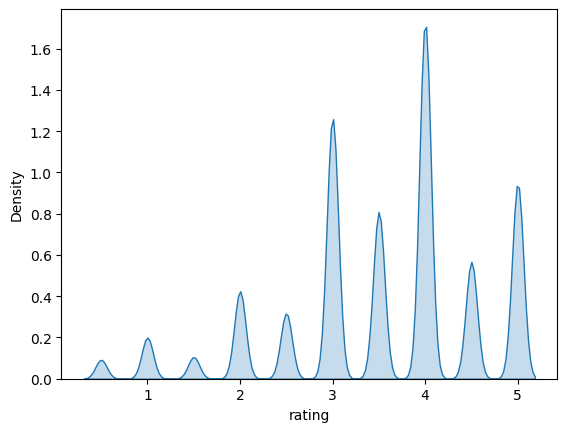

In [18]:
sns.kdeplot(data = ratings, x = 'rating', fill = True)
plt.show()

In [19]:
reader = Reader(rating_scale = (0.5, 5))

In [20]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [21]:
svd = SVD(n_factors=25, n_epochs=30, random_state=42, verbose=True)
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [22]:
id_to_names = {}

for id, name in zip(ratings['movieId'], ratings['movie_name']):
    id_to_names[id] = name

In [23]:
def anti_list(userid):
  fill = trainset.global_mean
  anti_list = list()
  u = trainset.to_inner_uid(userid)
  user_items = set([item_inner_id for item_inner_id, rating in trainset.ur[u]])
  anti_list += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for i in trainset.all_items() if i not in user_items]
  return anti_list

In [24]:
def topn(userid, n=5):
  anti_testset = anti_list(userid)
  predict = svd.test(anti_testset)
  recommended = list()
  for uid, iid, actual_rating, estimated, _ in predict:
    mov_id = int(iid)
    recommended.append((mov_id, estimated))
  recommended.sort(key = lambda x: x[1], reverse = True)

  movie_name = []
  movie_rat = []

  for name, rating in recommended[:n]:
      movie_name.append(id_to_names[name])
      movie_rat.append(rating)

  return pd.DataFrame({'movie_name': movie_name, 'movie_estrat': movie_rat})

In [25]:
topn(18, 5)

,movie_name,movie_estrat
0,Captain America: The Winter Soldier,4.412088
1,"Dark Knight, The",4.328344
2,"Hangover, The",4.234825
3,Iron Man,4.231963
4,Too Many Cooks,4.204935


In [26]:
print('='*150)

In [27]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
movies['content'] = movies['genres'].str.replace('|', ' ')

In [29]:
movies['content'] = movies['content'].str.lower()

In [30]:
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
movies.isna().sum()

,0
movieId,0
title,0
genres,0
content,0


In [32]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [33]:
movies.shape

(62423, 4)

In [34]:
movies.duplicated().sum()

0

In [35]:
movies['movie_release_year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['movie_name'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [36]:
movies['movie_name'] = movies['movie_name'].str.lower()

In [37]:
content = movies['movie_name']+' '+movies['content']
content.head()

,0
0,toy story adventure animation children comedy ...
1,jumanji adventure children fantasy
2,grumpier old men comedy romance
3,waiting to exhale comedy drama romance
4,father of the bride part ii comedy


In [38]:
tf = TfidfVectorizer()

transformed_features = tf.fit_transform(content)

In [ ]:
similarity = cosine_similarity(transformed_features)

In [ ]:
all_movies_list = df['title'].tolist()

In [ ]:
def recommend_movie(movie_name, df, sim):
    user_input = movie_name
    close_match= difflib.get_close_matches(user_input, all_movies_list, n = 5)[0]

    idx = df[df['title'] == close_match].index[0]
    similarity_score = list(enumerate(sim[idx]))
    sorted_score = sorted(similarity_score, key = lambda x:x[1], reverse = True)

    top_sim_score = sorted_score[1:11]
    rec_movies = [i[0] for i in top_sim_score]

    movies_list = df.iloc[rec_movies][['title', 'release_year']]

    return movies_list

In [ ]:
recommend_movie('iron man', movies, similarity)

==============================================================================================

In [ ]:
userid = int(input('Enter your userid: '))
movie_name = input('Enter your movie name: ')


def hybrid():
  colabarative = topn(userid, n)
  content_based = recommend_movie(movie_name, movies, similarity)
  return colabarative.merge(content_based, on = 'movie_name')